# Modelos Multinivel

Juan Sosa PhD

Email: jcsosam@unal.edu.co

GitHub: https://github.com/jstats1702

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import geopandas as gpd

from matplotlib.lines import Line2D
from matplotlib.colors import to_hex
from matplotlib.patches import Patch
from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import gaussian_kde
from scipy.special import gammaln
from tabulate import tabulate
from collections import Counter
from sklearn.cluster import KMeans

# Introducción

El tipo más simple de **datos multinivel** contempla **dos niveles**: **grupos** y **unidades dentro de los grupos**.

Se denota con $y_{i,j}$ la observación correspondiente a la unidad $i$ del grupo $j$, donde $i = 1,\ldots,n_j$ y $j = 1,\ldots,m$, siendo $m$ el número total de grupos y $n = \sum_{j=1}^m n_j$ el tamaño total de la muestra.

El **conjunto de datos** se representa como $\boldsymbol{y} = (\boldsymbol{y}_1,\ldots,\boldsymbol{y}_m)$, donde $\boldsymbol{y}_j = (y_{1,j},\ldots,y_{n_j,j})$ contiene las observaciones del grupo $j$, para $j = 1,\ldots,m$.


# Modelo Normal multinivel

Un modelo ampliamente utilizado para describir la **heterogeneidad de las medias** entre distintas poblaciones es el **modelo jerárquico Normal**, en el cual la **variabilidad dentro y entre los grupos** se representa mediante **distribuciones Normales**:

* **Caracterización dentro de los grupos:**

$$
y_{i,j} \mid \theta_j, \sigma^2 \overset{\text{ind}}{\sim} \textsf{N}(\theta_j, \sigma^2)
$$

* **Caracterización entre los grupos:**

$$
\theta_j \mid \mu, \tau^2 \overset{\text{iid}}{\sim} \textsf{N}(\mu, \tau^2)
$$

* **Distribución previa conjunta:**

$$
p(\sigma^2, \mu, \tau^2) = p(\sigma^2)\, p(\mu)\, p(\tau^2)
$$

con especificaciones:

$$
\sigma^2 \sim \textsf{GI}\left(\tfrac{\nu_0}{2}, \tfrac{\nu_0\, \sigma^2_0}{2}\right), \qquad \mu \sim \textsf{N}(\mu_0, \gamma_0^2), \qquad \tau^2 \sim \textsf{GI}\left(\tfrac{\eta_0}{2}, \tfrac{\eta_0\, \tau^2_0}{2}\right)
$$

* Los **parámetros** del modelo son $\boldsymbol{\theta} = (\theta_1, \ldots, \theta_m, \sigma^2, \mu, \tau^2)$.

* Los **hiperparámetros** del modelo son $(\nu_0, \sigma^2_0, \mu_0, \gamma_0^2, \eta_0, \tau^2_0)$.

## Entrenamiento

La estimación de los parámetros del modelo se puede hacer por medio de un **muestreador de Gibbs** para obtener muestras de la distribución posterior $p(\boldsymbol{\theta}\mid\boldsymbol{y})$.

- **(Ejercicio.)** Distribución posterior:
$$
\begin{aligned}
p(\boldsymbol{\theta} \mid \boldsymbol{y}) &\propto p(\boldsymbol{y} \mid \boldsymbol{\theta})\, p(\boldsymbol{\theta}) \\
&=\prod_{j=1}^m\prod_{i=1}^{n_j} \textsf{N}\left(y_{i, j} \mid \theta_{j}, \sigma^{2}\right) \\
&\quad\quad\times \prod_{j=1}^m \textsf{N}\left(\theta_{j} \mid \mu, \tau^{2}\right) \times
\textsf{GI}\left(\sigma^{2} \mid \tfrac{\nu_{0}}{2}, \tfrac{\nu_{0}\,\sigma_{0}^{2}}{2} \right) \\
&\quad\quad\quad\quad\times \textsf{N}\left(\mu \mid \mu_{0}, \gamma_{0}^{2}\right) \times \textsf{GI}\left(\tau^{2} \mid \tfrac{\eta_{0}}{2}, \tfrac{\eta_{0}\,\tau_{0}^{2}}{2}\right)
\end{aligned}
$$

- **(Ejercicio.)** Distribuciones condicionales completas:
$$
\begin{aligned}
\theta_{j} \mid - &\sim \textsf{N}\left( \frac{\mu / \tau^{2} + n_{j} \bar{y}_{j} / \sigma^{2}}{1 / \tau^{2} + n_{j} /\sigma^{2}}, \frac{1}{1 / \tau^{2} + n_{j} /\sigma^{2}}\right) \\
\sigma^{2} \mid - &\sim\textsf{GI}\left( \frac{\nu_{0}+\sum_{j=1}^m n_{j}}{2}, \frac{\nu_{0} \sigma_{0}^{2}+\sum_{j=1}^m \sum_{i=1}^{n_j}\left(y_{i, j}-\theta_{j}\right)^{2}}{2}\right) \\
\mu \mid - &\sim\textsf{N}\left( \frac{\mu_{0} / \gamma_{0}^{2} + m \bar{\theta} / \tau^{2}}{1 / \gamma_{0}^{2} + m / \tau^{2}}, \frac{1}{1 / \gamma_{0}^{2} + m / \tau^{2}}\right) \\
\tau^{2} \mid - &\sim\textsf{ GI }\left(\frac{\eta_{0}+m}{2}, \frac{\eta_{0} \tau_{0}^{2}+\sum_{j=1}^m\left(\theta_{j}-\mu\right)^{2}}{2}\right)
\end{aligned}
$$

# Ejemplo: Puntajes de Matemáticas

La base de datos contiene información proveniente de una **muestra aleatoria simple** de los **estudiantes que presentaron la Prueba Saber 11 en el segundo semestre de 2023**.

La **prueba de matemáticas** está construida sobre una **escala de 0 a 100** (sin decimales), con un **puntaje promedio de 50** y una **desviación estándar de 10 puntos**.

El objetivo es **construir un modelo para el puntaje de matemáticas a nivel nacional**, utilizando como datos de entrenamiento los resultados del segundo semestre de 2023, con el propósito de **realizar inferencias sobre la población estudiantil tanto a nivel nacional como departamental**.

Por esta razón, se considera el **departamento de residencia del estudiante como variable de agrupamiento**.

Los datos son de acceso público y pueden consultarse en el siguiente [enlace](https://www.icfes.gov.co/data-icfes/).


## Estructura de los datos

- $y_{i,j}$:       puntaje de matemáticas del estudiante $i$ y en departamento $j$.
- $n_j\,\,$:       número de estudiantes en el departamento $j$.
- $\bar{y}_j\,\,$: promedio muestral del departamento $j$.
- $s^2_j\,\,$:     varianza muestral del departamento $j$.


## Tratamiento de datos

In [4]:
# Datos
dat = pd.read_csv("SB11_20232_muestra.txt", sep=";")
dat = dat.sort_values(by="ESTU_COD_RESIDE_MCPIO")

# Dimensiones
print(dat.shape)

# Distribución de frecuencias
print(dat["ESTU_DEPTO_RESIDE"].value_counts())

(5511, 83)
ESTU_DEPTO_RESIDE
BOGOTÁ             776
ANTIOQUIA          758
VALLE              401
CUNDINAMARCA       389
ATLANTICO          342
BOLIVAR            275
SANTANDER          274
CORDOBA            218
MAGDALENA          200
BOYACA             173
TOLIMA             170
CESAR              149
NORTE SANTANDER    147
NARIÑO             145
CAUCA              126
HUILA              126
RISARALDA          125
META               122
SUCRE              107
LA GUAJIRA         100
CALDAS              78
CHOCO               55
CASANARE            53
QUINDIO             45
CAQUETA             42
PUTUMAYO            38
ARAUCA              34
GUAVIARE            15
SAN ANDRES           9
AMAZONAS             8
GUAINIA              4
VICHADA              4
VAUPES               3
Name: count, dtype: int64


In [5]:
# m: número de grupos (departamentos)
m = dat["ESTU_DEPTO_RESIDE"].nunique()
print("m =", m)

# n: número de individuos (estudiantes)
n = dat["ESTU_DEPTO_RESIDE"].value_counts().sum()
print("n =", n)

m = 33
n = 5511


In [6]:
# Variable de interés
y = dat["PUNT_MATEMATICAS"].values  # vector numpy

# Preparar lista de listas Y y vector g
m = dat["ESTU_DEPTO_RESIDE"].nunique()
n = dat.shape[0]

Y = [None] * m
g = np.empty(n, dtype=int)

# Crear identificadores secuenciales y listas por grupo
departamentos_ordenados = sorted(dat["ESTU_COD_RESIDE_DEPTO"].unique())
for j in range(m):
    cod_j = departamentos_ordenados[j]
    idx = dat["ESTU_COD_RESIDE_DEPTO"] == cod_j
    g[idx.values] = j + 1  # índice desde 1 (como en R)
    Y[j] = y[idx.values]

# Tabla de estadísticas por departamento
estadisticos = (
    dat.groupby("ESTU_COD_RESIDE_DEPTO")
    .agg(
        codigo=("ESTU_COD_RESIDE_DEPTO", "first"),
        nombre=("ESTU_DEPTO_RESIDE", "first"),
        nj=("PUNT_MATEMATICAS", "count"),
        yb=("PUNT_MATEMATICAS", "mean"),
        s2=("PUNT_MATEMATICAS", "var")
    )
    .reset_index(drop=True)
)

In [7]:
# Mostrar las primeras 10 filas de la tabla de estadísticos
print(estadisticos.head(10))

   codigo     nombre   nj         yb          s2
0       5  ANTIOQUIA  758  49.935356  139.822764
1       8  ATLANTICO  342  50.096491  140.415882
2      11     BOGOTÁ  776  55.082474  143.848673
3      13    BOLIVAR  275  46.803636  176.632833
4      15     BOYACA  173  54.040462  150.004167
5      17     CALDAS   78  52.217949  118.588245
6      18    CAQUETA   42  50.071429  167.043554
7      19      CAUCA  126  48.023810  163.927429
8      20      CESAR  149  50.543624  136.560584
9      23    CORDOBA  218  49.096330  181.728005


In [8]:
# Tamaños de muestra
nj = estadisticos["nj"].values

# Estadísticos suficientes
yb = estadisticos["yb"].values
s2 = estadisticos["s2"].values

## Análisis exploratorio

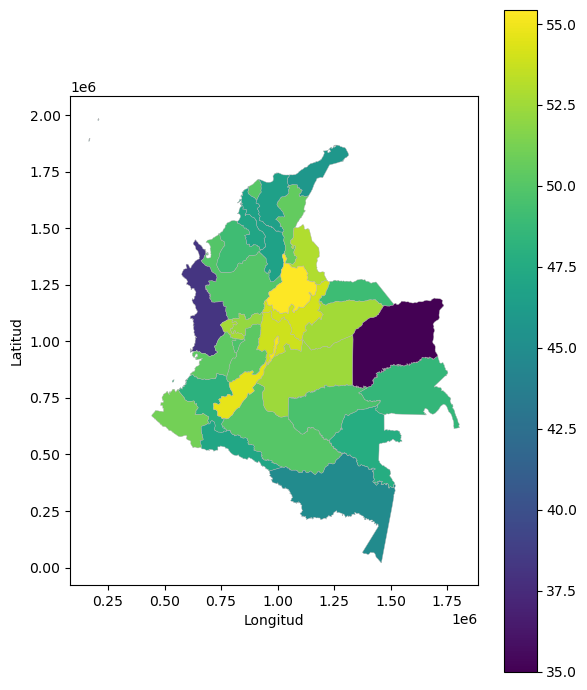

In [10]:
# Leer shapefile
shp = gpd.read_file("depto.shp")

# Preparar datos de promedio por departamento
pd_map = estadisticos[["codigo", "yb"]].copy()
pd_map["codigo"] = pd_map["codigo"].astype(str)

# Normalizar códigos con ceros a la izquierda (por si hay códigos de 1 dígito)
pd_map["codigo"] = pd_map["codigo"].str.zfill(2)

# Renombrar columnas para el merge
pd_map.columns = ["DPTO", "Media"]

# Unir shapefile con los datos
shp = shp.merge(pd_map, on="DPTO")

# Graficar el mapa
fig, ax = plt.subplots(1, 1, figsize=(6, 7))  # tamaño ajustado

shp.plot(
    column="Media",
    cmap="viridis",
    linewidth=0.3,
    edgecolor="#b2b2b2",
    ax=ax,
    legend=True
)

# Estilo y etiquetas
ax.set_title("", fontsize=12)
ax.set_xlabel("Longitud")
ax.set_ylabel("Latitud")
plt.tight_layout()
plt.show()

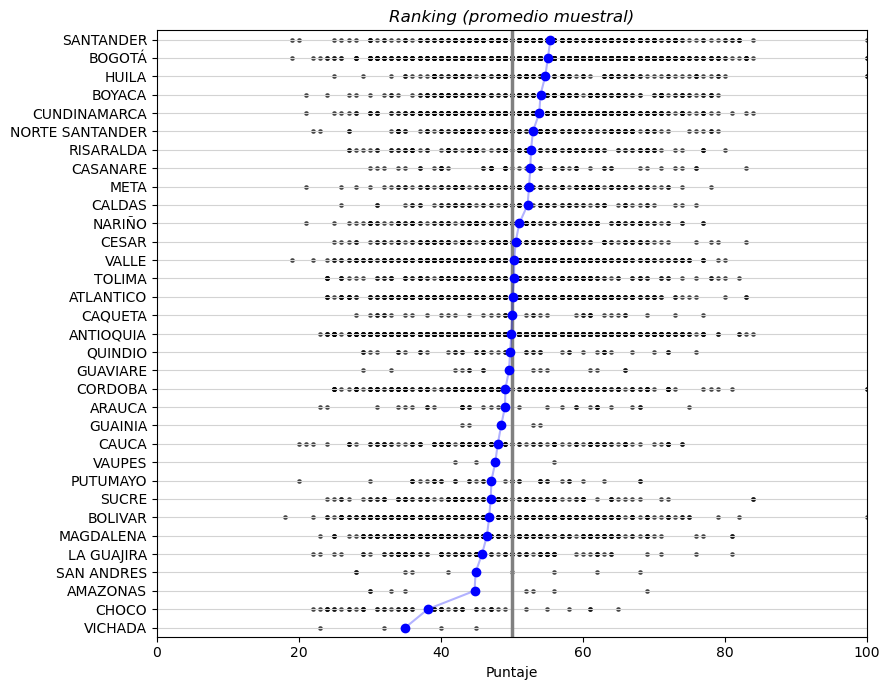

In [11]:
# Ordenar de mayor a menor promedio
yb_order = np.argsort(-yb)
yb_sorted = yb[yb_order]
nj_sorted = nj[yb_order]
Y_sorted = [Y[j] for j in yb_order]
nombres_sorted = estadisticos["nombre"].values[yb_order]

m = len(yb_sorted)

# Crear gráfico
fig, ax = plt.subplots(figsize=(9, 7))
ax.set_xlim(0, 100)
ax.set_ylim(0.5, m + 0.5)

# Etiquetas y título
ax.set_xlabel("Puntaje")
ax.set_title("Ranking (promedio muestral)", style="italic")
ax.set_yticks(range(1, m + 1))
ax.set_yticklabels(nombres_sorted)

# Invertir eje Y para que el mejor promedio quede arriba
ax.invert_yaxis()

# Líneas de referencia horizontales
ax.grid(True, axis='y', color="lightgray", linewidth=0.8)

# Línea vertical en el promedio nacional (50)
ax.axvline(x=50, color="gray", linewidth=2.5)

# Dibujar puntos individuales por departamento
for l in range(m):
    y_vals = Y_sorted[l]
    ax.scatter(y_vals, [l + 1] * len(y_vals), color="black", s=6, alpha=0.6)

# Puntos del promedio muestral
ax.plot(yb_sorted, range(1, m + 1), 'o', color="blue", markersize=6)

# Línea que conecta los promedios
ax.plot(yb_sorted, range(1, m + 1), '-', color="blue", alpha=0.3)

plt.tight_layout()
plt.show()

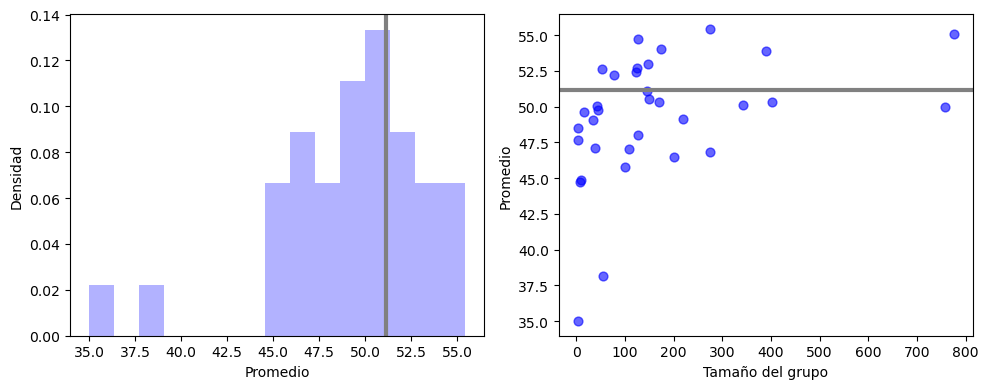

In [12]:
# Crear figura con dos paneles lado a lado
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Histograma del promedio por grupo
axs[0].hist(yb, bins=15, density=True,
            color=(0, 0, 1, 0.3), edgecolor=(0, 0, 1, 0.0))
axs[0].axvline(np.mean(y), color='gray', linewidth=3)
axs[0].set_xlabel("Promedio")
axs[0].set_ylabel("Densidad")
axs[0].set_title("")

# Diagrama de dispersión: tamaño del grupo vs. promedio
axs[1].scatter(nj, yb, color=(0, 0, 1, 0.6), s=40)
axs[1].axhline(np.mean(y), color='gray', linewidth=3)
axs[1].set_xlabel("Tamaño del grupo")
axs[1].set_ylabel("Promedio")

# Ajuste del diseño
plt.tight_layout()
plt.show()

Es habitual que los grupos con promedios muestrales extremadamente altos o bajos correspondan a aquellos con tamaños muestrales reducidos.


## Distribución previa

Teniendo en cuenta la información de la prueba, el modelo se ajusta utilizando los siguientes hiperparámetros: 
$$
\mu_0 = 50\,,\qquad
\gamma^2_0 = 10^2\,,\qquad
\eta_0 = 1\,,\qquad
\tau^2_0 = 10^2\,,\qquad
\nu_0 = 1\,,\qquad
\sigma^2_0 = 10^2\,.
$$

In [14]:
# Hiperparámetros
mu0  = 50
g20  = 10**2

eta0 = 1
t20  = 10**2

nu0  = 1
s20  = 10**2

1. Inicializar $\theta_1,\ldots,\theta_m$, $\sigma^2$, $\mu$, $\tau^2$.
2. Repetir para $b = 1, \ldots, B$:

     - Actualizar $\theta_j \, \sim p(\theta_j \mid -)$.
     - Actualizar $\sigma^2 \sim p(\sigma^2 \mid -)$.
     - Actualizar $\mu      \,\,\sim p(\mu      \mid -)$.
     - Actualizar $\tau^2   \sim p(\tau^2   \mid -)$.
     - Calcular log-verosimilitud con $\boldsymbol{y} \mid \theta_1,\ldots,\theta_m, \sigma^2$.
     - Almacenar parámetros y log-verosimilitud.
   
3. Devolver la cadena simulada.

In [16]:
def MCMC1(B, y, nj, yb, s2, mu0, g20, eta0, t20, nu0, s20):
    # Validación de entradas
    y = np.asarray(y)
    yb = np.asarray(yb)
    s2 = np.asarray(s2)
    nj = np.asarray(nj)

    assert len(yb) == len(s2) == len(nj), "yb, s2 y nj deben tener la misma longitud"
    assert np.sum(nj) == len(y), "La suma de nj debe coincidir con la longitud de y"

    ncat = B // 10
    n = np.sum(nj)
    m = len(nj)

    # Inicialización
    theta = yb.copy()
    sig2 = np.mean(s2)
    mu = np.mean(theta)
    tau2 = np.var(theta, ddof=1)

    # Determinar tamaño correcto de la fila
    n_params = len(theta) + 4
    THETA = np.empty((B, n_params))
    THETA[:] = np.nan

    for b in range(B):
        # Actualizar theta_j
        v_theta = 1 / (1 / tau2 + nj / sig2)
        m_theta = v_theta * (mu / tau2 + nj * yb / sig2)
        theta = np.random.normal(loc=m_theta, scale=np.sqrt(v_theta))

        # Actualizar sigma^2
        a_sig2 = 0.5 * (nu0 + n)
        b_sig2 = 0.5 * (nu0 * s20 + np.sum((nj - 1) * s2 + nj * (yb - theta)**2))
        sig2 = 1 / np.random.gamma(shape=a_sig2, scale=1 / b_sig2)

        # Actualizar mu
        v_mu = 1 / (1 / g20 + m / tau2)
        m_mu = v_mu * (mu0 / g20 + m * np.mean(theta) / tau2)
        mu = np.random.normal(loc=m_mu, scale=np.sqrt(v_mu))

        # Actualizar tau^2
        a_tau2 = 0.5 * (eta0 + m)
        b_tau2 = 0.5 * (eta0 * t20 + (m - 1) * np.var(theta, ddof=1) + m * (np.mean(theta) - mu)**2)
        tau2 = 1 / np.random.gamma(shape=a_tau2, scale=1 / b_tau2)

        # Log-verosimilitud
        rep_theta = np.repeat(theta, nj)
        ll = np.sum(norm.logpdf(y, loc=rep_theta, scale=np.sqrt(sig2)))

        # Concatenar todos los valores muestreados
        fila = np.concatenate([theta, [sig2, mu, tau2, ll]])
        THETA[b, :] = fila  # esta asignación ahora siempre tiene la dimensión correcta

        if (b + 1) % ncat == 0:
            print(f"{int(100 * (b + 1) / B)}% completado ...")

    colnames = [f"theta{j}" for j in range(len(theta))] + ["sig2", "mu", "tau2", "ll"]

    return {"THETA": pd.DataFrame(THETA, columns=colnames)}

In [17]:
# Ajuste del modelo
np.random.seed(123)
chain1 = MCMC1(B=10000, y=y, nj=nj, yb=yb, s2=s2, mu0=mu0, g20=g20, eta0=eta0, t20=t20, nu0=nu0, s20=s20)

10% completado ...
20% completado ...
30% completado ...
40% completado ...
50% completado ...
60% completado ...
70% completado ...
80% completado ...
90% completado ...
100% completado ...


## Convergencia

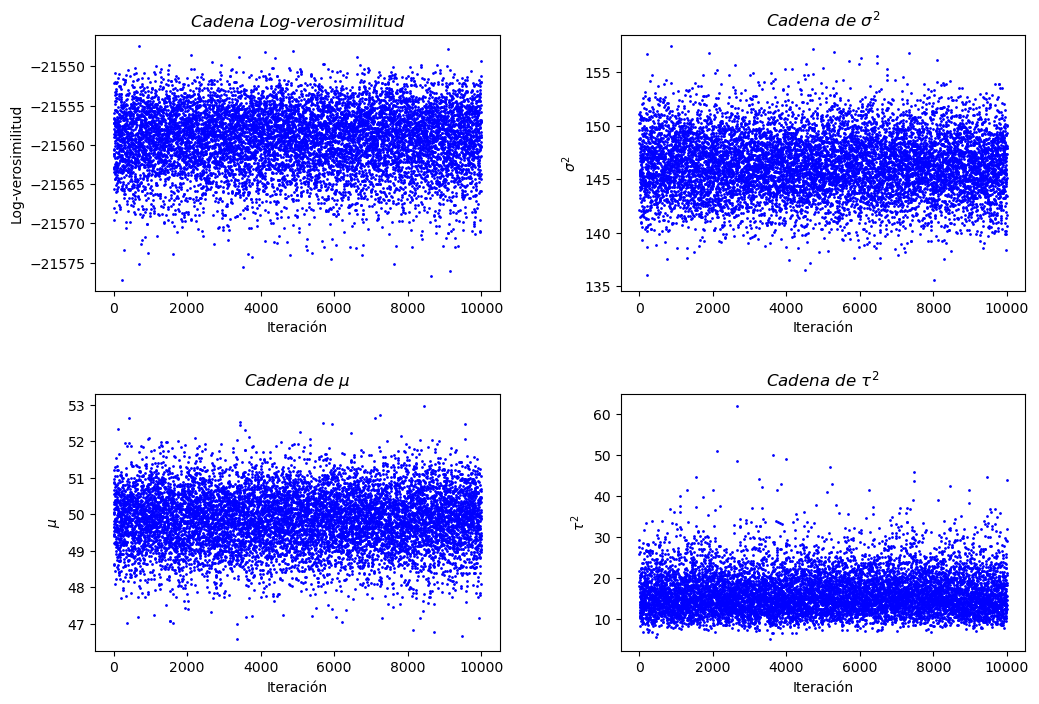

In [19]:
# Extraer la cadena
theta_df = chain1["THETA"]

# Configurar el gráfico: 2 filas x 2 columnas
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# Log-verosimilitud
axs[0, 0].plot(theta_df["ll"], marker='.', linestyle='none', markersize=2, color='blue')
axs[0, 0].set_title("Cadena Log-verosimilitud", style='italic')
axs[0, 0].set_xlabel("Iteración")
axs[0, 0].set_ylabel("Log-verosimilitud")

# Varianza dentro de grupo (sigma^2)
axs[0, 1].plot(theta_df["sig2"], marker='.', linestyle='none', markersize=2, color='blue')
axs[0, 1].set_title(r"Cadena de $\sigma^2$", style='italic')
axs[0, 1].set_xlabel("Iteración")
axs[0, 1].set_ylabel(r"$\sigma^2$")

# Media global (mu)
axs[1, 0].plot(theta_df["mu"], marker='.', linestyle='none', markersize=2, color='blue')
axs[1, 0].set_title(r"Cadena de $\mu$", style='italic')
axs[1, 0].set_xlabel("Iteración")
axs[1, 0].set_ylabel(r"$\mu$")

# Varianza entre grupos (tau^2)
axs[1, 1].plot(theta_df["tau2"], marker='.', linestyle='none', markersize=2, color='blue')
axs[1, 1].set_title(r"Cadena de $\tau^2$", style='italic')
axs[1, 1].set_xlabel("Iteración")
axs[1, 1].set_ylabel(r"$\tau^2$")

plt.show()

In [20]:
def effective_size(x, max_lag=1000):
    """
    Calcula el tamaño efectivo de muestra (ESS) siguiendo el criterio de Geyer,
    equivalente a coda::effectiveSize en R.

    Parámetros:
    - x: array unidimensional con la cadena MCMC.
    - max_lag: número máximo de retardos (por defecto 1000).

    Retorna:
    - ESS: tamaño efectivo de muestra.
    """
    x = np.asarray(x)
    n = len(x)
    x_centered = x - np.mean(x)
    var = np.var(x_centered, ddof=0)

    # Autocorrelaciones (biased estimator)
    acf = np.correlate(x_centered, x_centered, mode='full')[n-1:] / (var * n)
    acf = acf[:max_lag]

    # Geyer truncation: usar pares de autocorrelaciones mientras su suma sea positiva
    t = 1
    while t + 1 < len(acf) and (acf[t] + acf[t + 1]) > 0:
        t += 2

    # Suma truncada
    tau = 1 + 2 * np.sum(acf[1:t])
    ess = n / tau
    return ess

In [21]:
# Tamaños efectivos de muestra (ESS) por columna
theta_df = chain1["THETA"]
neff1 = theta_df.apply(effective_size)

# Error estándar Monte Carlo (EEMC)
EEMC1 = theta_df.std(ddof=1) / np.sqrt(neff1)

# Coeficiente de variación Monte Carlo (en %)
CVMC1 = 100 * (EEMC1.abs() / theta_df.mean().abs())

# Resumen del tamaño efectivo de muestra
print("Tamaño efectivo de muestra:")
print(neff1.round(2).describe())

# Resumen del coeficiente de variación de Monte Carlo (CVMC1)
print("Coeficiente de variación Monte Carlo (%):")
print(CVMC1.round(2).describe())

Tamaño efectivo de muestra:
count       37.000000
mean      9422.053784
std        884.283517
min       5978.810000
25%       9244.440000
50%       9709.800000
75%      10000.000000
max      10000.000000
dtype: float64
Coeficiente de variación Monte Carlo (%):
count    37.000000
mean      0.038919
std       0.064497
min       0.000000
25%       0.020000
50%       0.020000
75%       0.040000
max       0.400000
dtype: float64


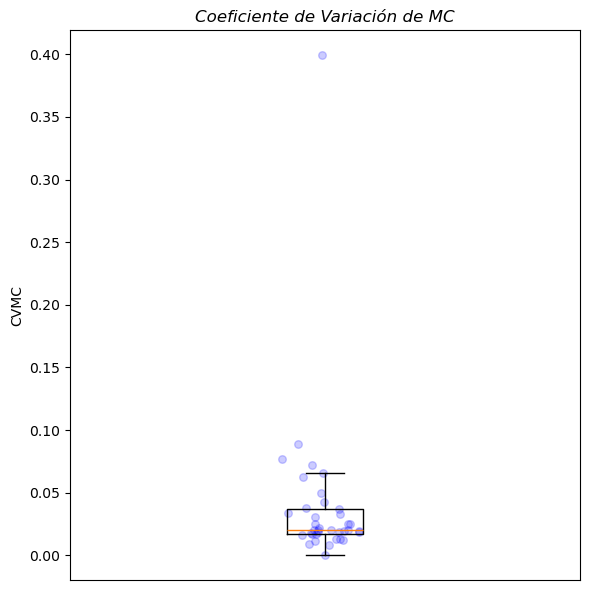

In [22]:
# Semilla para reproducibilidad del jitter
np.random.seed(123)

# Extraer los valores
cvmc_vals = CVMC1.values
m = len(cvmc_vals) - 4  # número de thetas

# Crear figura
fig, ax = plt.subplots(figsize=(6, 6))

# Boxplot sin outliers
ax.boxplot(cvmc_vals, patch_artist=False, showfliers=False)

# Agregar puntos individuales con jitter
x_jitter = 1 + 0.03 * np.random.randn(len(cvmc_vals))  # jitter horizontal
ax.scatter(x_jitter, cvmc_vals, color=(0, 0, 1, 0.2), s=30)

# Etiquetas y estilo
ax.set_ylabel("CVMC")
ax.set_title("Coeficiente de Variación de MC", style='italic')
ax.set_xticks([])  # quitar eje x

plt.tight_layout()
plt.show()

## Inferencia

Se define $\eta$ como la proporción de intravarianza: $\eta = 100\cdot\frac{\sigma^2}{\sigma^2+\tau^2}\%$.

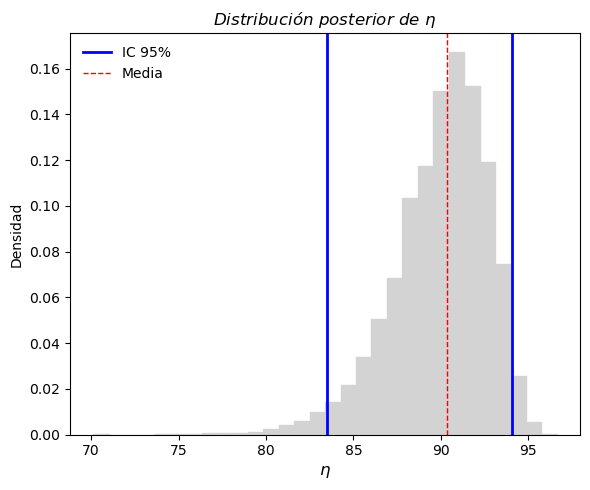

In [24]:
# Calcular cantidades derivadas
theta_df = chain1["THETA"]
eta = 100 * theta_df["sig2"] / (theta_df["sig2"] + theta_df["tau2"])  # % varianza dentro del grupo
mu_post = theta_df["mu"]
sd_within = np.sqrt(theta_df["sig2"])
sd_between = np.sqrt(theta_df["tau2"])

# Almacenar en una matriz estilo PAR (por si se requiere luego)
PAR = np.column_stack([eta, mu_post, sd_within, sd_between])

# Histograma de eta
fig, ax = plt.subplots(figsize=(6, 5))
ax.hist(PAR[:, 0], bins=30, density=True, color="lightgray", edgecolor="lightgray")

# Líneas verticales en los cuantiles 2.5%, 50%, 97.5%
q = np.quantile(PAR[:, 0], [0.025, 0.5, 0.975])
ax.axvline(q[0], color='blue', linestyle='-', linewidth=2)   # 2.5%
ax.axvline(q[1], color='red', linestyle='--', linewidth=1)   # 50%
ax.axvline(q[2], color='blue', linestyle='-', linewidth=2)   # 97.5%

# Etiquetas
ax.set_xlabel(r"$\eta$", fontsize=12)
ax.set_ylabel("Densidad")
ax.set_title(r"Distribución posterior de $\eta$", style='italic')

# Leyenda
ax.legend(["IC 95%", "Media"],
          loc="upper left", frameon=False,
          fontsize=10, handlelength=2)

plt.tight_layout()
plt.show()

- El 90.0% de la variabilidad total en los puntajes se explica por las diferencias dentro de los departamentos.  
- La media global de los puntajes es cercana a 50.  
- El 99.7% de los puntajes individuales dentro de los departamentos se encuentran a una distancia máxima de $3 \times 12.1 = 36.3$ puntos.  
- El 99.7% de los promedios de puntajes entre departamentos están separados por una distancia máxima de $3 \times 4.0 = 12.0$ puntos.

In [26]:
# Crear DataFrame con nombres de columnas
colnames = ["eta", "mu", "sig", "tau"]
df_par = pd.DataFrame(PAR, columns=colnames)

# Construir tabla resumen
tab = pd.DataFrame({
    "Media": df_par.mean(),
    "CV(%)": 100 * df_par.std(ddof=1).abs() / df_par.mean(),
    "Q2.5%": df_par.quantile(0.025),
    "Q97.5%": df_par.quantile(0.975)
})

# Transponer y redondear
tab = tab.round(3)

# Mostrar en formato markdown
print(tab.to_markdown())

|     |   Media |   CV(%) |   Q2.5% |   Q97.5% |
|:----|--------:|--------:|--------:|---------:|
| eta |  89.928 |   3.039 |  83.499 |   94.07  |
| mu  |  49.858 |   1.568 |  48.236 |   51.321 |
| sig |  12.098 |   0.956 |  11.872 |   12.329 |
| tau |   4.023 |  14.899 |   3.038 |    5.374 |


## Ranking

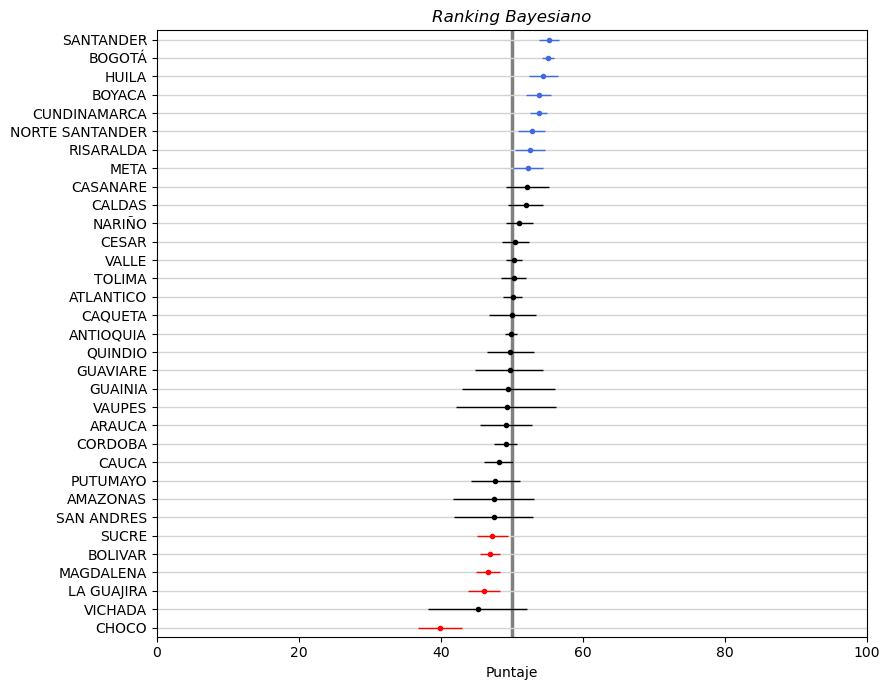

In [28]:
# Nombres de los grupos
ids2 = estadisticos["nombre"].values
m = len(ids2)

# Medias posteriores y muestras de theta
theta_df = chain1["THETA"]
theta_cols = [f"theta{j}" for j in range(m)]
theta_samples = theta_df[theta_cols].to_numpy()

that = theta_samples.mean(axis=0)
ic1 = np.quantile(theta_samples, q=[0.025, 0.975], axis=0)

# Ordenar de mayor a menor media posterior
ranking = np.argsort(-that)
ids2 = ids2[ranking]
that = that[ranking]
ic1 = ic1[:, ranking]

# Colores por intervalo de credibilidad
colo = np.full(m, 1)  # negro por defecto
colo[ic1[0, :] > 50] = 0  # azul si IC > 50
colo[ic1[1, :] < 50] = 2  # rojo si IC < 50
color_map = ["royalblue", "black", "red"]
colo = [color_map[c] for c in colo]

# Gráfico del ranking bayesiano
fig, ax = plt.subplots(figsize=(9, 7))
ax.set_xlim(0, 100)
ax.set_ylim(0.5, m + 0.5)

ax.set_xlabel("Puntaje")
ax.set_title("Ranking Bayesiano", style='italic')
ax.set_yticks(range(1, m + 1))
ax.set_yticklabels(ids2)

# Invertir eje Y para que el mejor promedio esté arriba
ax.invert_yaxis()

# Línea vertical en 50
ax.axvline(x=50, color="gray", linewidth=2.5)

# Líneas horizontales de referencia
for j in range(1, m + 1):
    ax.axhline(y=j, color="lightgray", linewidth=1)

# Dibujar intervalos y medias
for j in range(m):
    ax.hlines(y=j + 1, xmin=ic1[0, j], xmax=ic1[1, j], color=colo[j], linewidth=1)
    ax.plot(that[j], j + 1, 'o', color=colo[j], markersize=3)

plt.tight_layout()
plt.show()

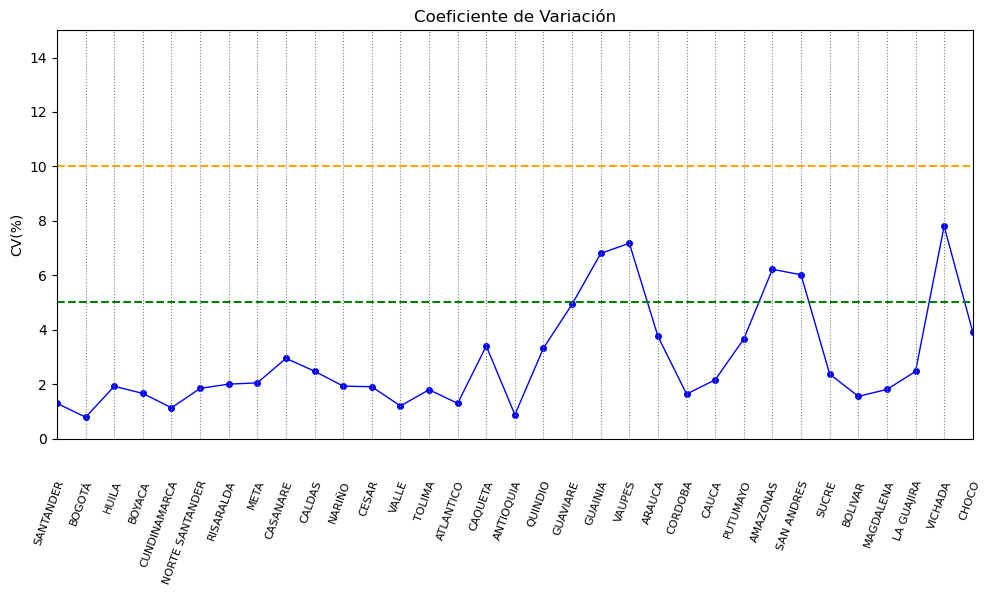

In [29]:
# Extraer cadena MCMC de thetas
theta_df = chain1["THETA"]
m = len(estadisticos)
theta_cols = [f"theta{j}" for j in range(m)]
theta_samples = theta_df[theta_cols].to_numpy()

# Medias y desviaciones estándar por grupo
that = theta_samples.mean(axis=0)
shat = theta_samples.std(axis=0, ddof=1)

# Ordenar por media posterior decreciente
ranking = np.argsort(-that)
cv_b = 100 * np.abs(shat / that)[ranking]
ids2 = estadisticos["nombre"].values[ranking]

# Gráfico
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(range(1, m + 1), cv_b, marker='o', color='blue', linewidth=1, markersize=4)
ax.set_ylabel("CV(%)")
ax.set_ylim(0, 15)
ax.set_xlim(1, m)
ax.set_title("Coeficiente de Variación")
ax.set_xticks([])  # sin etiquetas aún

# Etiquetas del eje x con rotación
for i in range(m):
    ax.text(i + 1 + 0.3, -1.5, ids2[i], rotation=70,
            ha='right', va='top', fontsize=8, clip_on=False)

# Líneas verticales claras por grupo
for i in range(1, m + 1):
    ax.axvline(x=i, color="gray", linestyle="dotted", linewidth=0.8)

# Líneas horizontales de referencia
ax.axhline(y=5, color="green", linestyle="--")
ax.axhline(y=10, color="#FFA500", linestyle="--")  # naranja
ax.axhline(y=15, color="red", linestyle="--")

# Ajustar márgenes para mostrar las etiquetas
plt.subplots_adjust(bottom=0.3)
plt.tight_layout()
plt.show()

## Contracción 

La **contracción** (*shrinkage*) es un fenómeno donde las estimaciones de ciertos parámetros tienden a "acercarse" o "ajustarse" hacia un valor central o promedio. Este efecto ocurre generalmente debido a la **influencia de la previa** o a la **estructura jerárquica del modelo**. 

La contracción ayuda a **proporcionar estimaciones más moderadas y estables**, especialmente en escenarios donde los datos son limitados. 

Este ajuste **mejora la robustez de los resultados** al equilibrar la información observada con la información previa o el contexto global del modelo.

La contracción genera dependencia entre los grupos al asumir que sus parámetros comparten una distribución común. Esto provoca que las estimaciones de los **grupos con poca información se ajusten hacia el promedio global**, mientras que los **grupos con mayor cantidad de información se apoyen más en sus propios datos**.

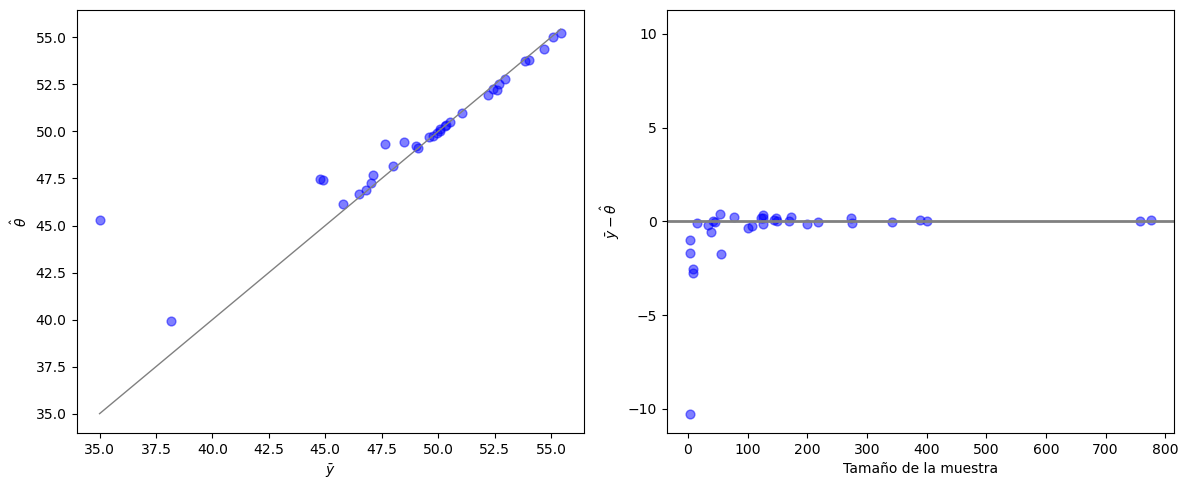

In [31]:
# Calcular la media posterior theta_hat para cada grupo
theta_samples = chain1["THETA"][[f"theta{j}" for j in range(m)]].to_numpy()
theta_hat = theta_samples.mean(axis=0)

# Comparación visual: contracción
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Primer gráfico: theta_hat vs. promedio muestral
axs[0].plot([yb.min(), yb.max()], [yb.min(), yb.max()], color="gray", linewidth=1)
axs[0].scatter(yb, theta_hat, color=(0, 0, 1, 0.5), s=40)
axs[0].set_xlabel(r"$\bar{y}$")
axs[0].set_ylabel(r"$\hat{\theta}$")
axs[0].set_title("")

# Segundo gráfico: diferencia vs. tamaño de muestra
delta = yb - theta_hat
axs[1].set_ylim(-np.max(np.abs(delta)) - 1, np.max(np.abs(delta)) + 1)
axs[1].axhline(y=0, color="gray", linewidth=2)
axs[1].scatter(nj, delta, color=(0, 0, 1, 0.5), s=40)
axs[1].set_xlabel("Tamaño de la muestra")
axs[1].set_ylabel(r"$\bar{y} - \hat{\theta}$")
axs[1].set_title("")

plt.tight_layout()
plt.show()

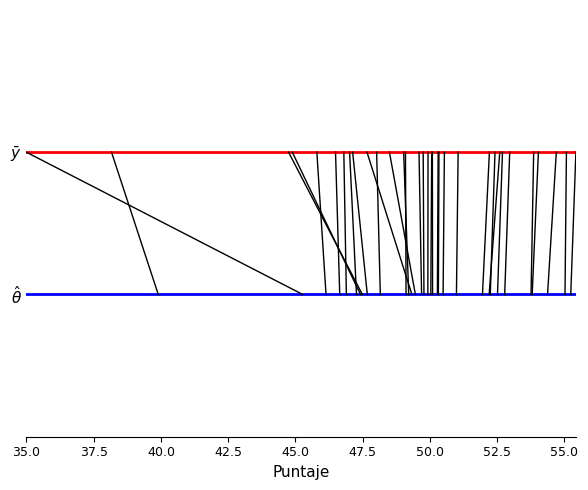

In [32]:
# Crear gráfico vacío con límites apropiados
fig, ax = plt.subplots(figsize=(6, 5))

# Limites en x: entre mínimo y máximo de theta_hat y yb
xmin = min(theta_hat.min(), yb.min())
xmax = max(theta_hat.max(), yb.max())
ax.set_xlim(xmin, xmax)
ax.set_ylim(1, 4)

# Ocultar eje y y reemplazar con etiquetas personalizadas
ax.set_yticks([2, 3])
ax.set_yticklabels([r"$\hat{\theta}$", r"$\bar{y}$"], fontsize=11)
ax.tick_params(axis='x', labelsize=9)
ax.set_xlabel("Puntaje", fontsize=11)
ax.set_title("")

# Líneas horizontales para las referencias
ax.axhline(y=2, color="blue", linewidth=2)
ax.axhline(y=3, color="red", linewidth=2)

# Dibujar líneas que conectan theta_hat y yb
for j in range(m):
    ax.plot([theta_hat[j], yb[j]], [2, 3], color="black", linewidth=1)

# Limpiar bordes
ax.spines[['right', 'top', 'left']].set_visible(False)
ax.tick_params(axis='y', length=0)

plt.tight_layout()
plt.show()

## Agrupamiento

Se aplica un algoritmo de segmentación (e.g., *k-means*) sobre las medias posteriores de $(\theta_1, \sigma^2_1), \ldots, (\theta_m, \sigma^2_m)$.

Para seleccionar el número óptimo de grupos, se implemente un *k-means* con distintos valores de $K$ (e.g., 2 a 15) y se calcula la suma de cuadrados intra-cluster (WSS, *within sum of squares*). A partir de la reducción relativa $\Delta_k = (\text{WSS}_{k-1} - \text{WSS}_{k})/\text{WSS}_{k-1}$, se elige el menor valor de $k$ tal que $\Delta_k < \varepsilon$ (e.g., $\varepsilon = 0.2$), es decir, el punto en que añadir más grupos no mejora sustancialmente el ajuste.

In [34]:
# Número de grupos (departamentos)
m = len(np.unique(dat["ESTU_DEPTO_RESIDE"]))

# Número de iteraciones (asumido igual a número de filas de chain1["THETA"])
B = chain1["THETA"].shape[0]

# Rango de valores de k a evaluar
k_range = range(2, 16)

# Umbral de mejora relativa
eps = 0.2

# Media posterior de cada grupo
theta_hat = chain1["THETA"].iloc[:, :m].mean(axis=0).values

# Inicializar almacenamiento para WSS y asignaciones
wss = []
clusters_list = []

# Evaluar KMeans para cada k
for k in k_range:
    km = KMeans(n_clusters=k, n_init=10, random_state=123).fit(theta_hat.reshape(-1, 1))
    wss.append(km.inertia_)  # total within-cluster sum of squares
    clusters_list.append(km.labels_)

# Calcular reducción relativa de WSS
wss = np.array(wss)
delta = np.abs(np.diff(wss)) / wss[:-1]

# Buscar el primer k con mejora relativa menor que eps
best_k_indices = np.where(delta < eps)[0]

# Seleccionar número óptimo de clusters
if len(best_k_indices) == 0:
    xi_hat = clusters_list[0]  # usar k = 2
else:
    xi_hat = clusters_list[best_k_indices[0] + 1]

# Número de clusters
K = len(np.unique(xi_hat))
print(f"Número óptimo de clusters: K = {K}")

Número óptimo de clusters: K = 11


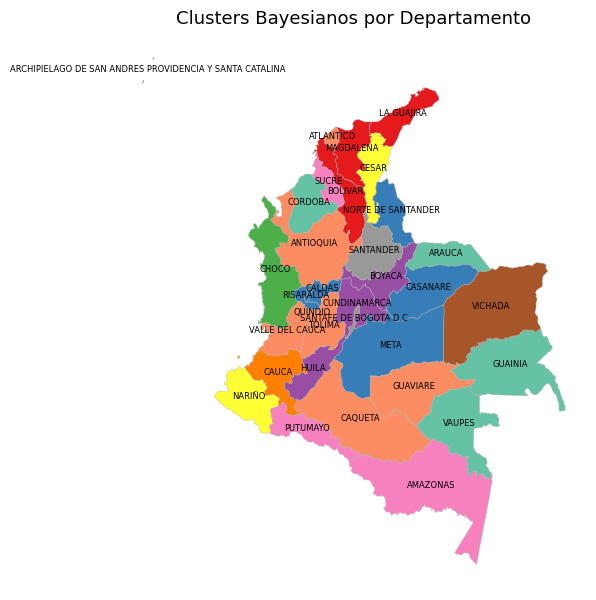

In [35]:
# Leer shapefile
shp = gpd.read_file("depto.shp")

# Preparar DataFrame con código y cluster
pd_map = estadisticos[["codigo"]].copy()
pd_map["codigo"] = pd_map["codigo"].astype(str)

# Normalizar códigos (ceros a la izquierda si es necesario)
pd_map["codigo"] = pd_map["codigo"].str.zfill(2)

# Agregar clusters
pd_map["Cluster"] = xi_hat
pd_map = pd_map.rename(columns={"codigo": "DPTO"})

# Unir shapefile con resultados de clustering
shp_clust = shp.merge(pd_map, on="DPTO")

# Asignar colores predefinidos (hasta 20)
colores = [
    "#E41A1C", "#377EB8", "#4DAF4A", "#984EA3", "#FF7F00",
    "#FFFF33", "#A65628", "#F781BF", "#999999", "#66C2A5",
    "#FC8D62", "#8DA0CB", "#E78AC3", "#A6D854", "#FFD92F",
    "#E5C494", "#B3B3B3", "#1B9E77", "#D95F02", "#7570B3"
][:K]

# Mapa con geopandas y matplotlib
fig, ax = plt.subplots(1, 1, figsize=(6, 7))
shp_clust.plot(
    color=[colores[i - 1] for i in shp_clust["Cluster"]],
    edgecolor="#b2b2b2",
    linewidth=0.3,
    ax=ax
)

# Añadir etiquetas con nombre del departamento
if "NOMBRE_DPT" in shp_clust.columns:
    shp_clust["coords"] = shp_clust["geometry"].centroid
    for idx, row in shp_clust.iterrows():
        x, y = row["coords"].x, row["coords"].y
        ax.text(x, y, row["NOMBRE_DPT"], fontsize=6, ha='center', color="black")

# Estilo del gráfico
ax.set_title("Clusters Bayesianos por Departamento", fontsize=13)
ax.set_axis_off()
plt.tight_layout()
plt.show()

# Modelo Normal con medidas y varianzas especificas

Una extensión natural del modelo normal multinivel consiste en permitir que **tanto la media como la varianza sean específicas para cada grupo**, capturando así diferencias tanto en tendencia central como en dispersión entre los grupos.

* **Modelo dentro de los grupos**:
$$
y_{i, j} \mid \theta_j, \sigma_j^2 \overset{\text{ind}}{\sim} \textsf{N}(\theta_j, \sigma_j^2)
$$

* **Modelo entre los grupos**:
$$
\theta_j \mid \mu, \tau^2 \overset{\text{iid}}{\sim} \textsf{N}(\mu, \tau^2)
\qquad
\sigma_j^2 \mid \nu, \sigma^2 \overset{\text{iid}}{\sim} \textsf{GI}\left(\tfrac{\nu}{2}, \tfrac{\nu\,\sigma^2}{2}\right)
$$

* **Distribución previa conjunta**:
$$
p(\mu, \tau^2, \nu, \sigma^2) = p(\mu)\,p(\tau^2)\,p(\nu)\,p(\sigma^2)
$$
con:
$$
\mu \sim \textsf{N}(\mu_0, \gamma_0^2),
\qquad
\tau^2 \sim \textsf{GI}\left(\tfrac{\eta_0}{2}, \tfrac{\eta_0\,\tau_0^2}{2}\right),
\qquad
p(\nu) \propto e^{-\lambda_0 \nu},
\qquad
\sigma^2 \sim \textsf{Gamma}(\alpha_0, \beta_0)
$$

* Los **parámetros** del modelo son:
$$
\boldsymbol{\theta} = (\theta_1, \ldots, \theta_m, \sigma_1^2, \ldots, \sigma_m^2, \mu, \tau^2, \nu, \sigma^2)
$$

* Los **hiperparámetros** son:
$$
(\mu_0, \gamma_0^2, \eta_0, \tau_0^2, \lambda_0, \alpha_0, \beta_0)
$$

## Entrenamiento

La estimación de los parámetros del modelo se puede hacer por medio de un **muestreador de Gibbs** para obtener muestras de la distribución posterior $p(\boldsymbol{\theta}\mid\boldsymbol{y})$.

- **(Ejercicio.)** Distribución posterior:
$$
\begin{aligned}
p(\boldsymbol{\theta} \mid \boldsymbol{y}) &\propto p(\boldsymbol{y} \mid \boldsymbol{\theta})\, p(\boldsymbol{\theta}) \\
&= \prod_{j=1}^m\prod_{i=1}^{n_j} \textsf{N}\left(y_{i, j} \mid \theta_{j}, \sigma_j^{2}\right) \\
&\quad\quad\times \prod_{j=1}^m \textsf{N}\left(\theta_{j} \mid \mu, \tau^{2}\right) \times \prod_{j=1}^m \textsf{GI}\left(\sigma^2_{j} \mid \tfrac{\nu}{2}, \tfrac{\nu\,\sigma^{2}}{2}\right) \\
&\quad\quad\quad\times \textsf{N}\left(\mu \mid \mu_{0}, \gamma_{0}^{2}\right) \times \textsf{GI}\left(\tau^{2} \mid \tfrac{\eta_{0}}{2}, \tfrac{\eta_{0}\,\tau_{0}^{2}}{2}\right) \\
&\quad\quad\quad\quad\times e^{-\lambda_0\,\nu} \times \textsf{G}(\sigma^2\mid\alpha_0,\beta_0)
\end{aligned}
$$

- **(Ejercicio.)** Distribuciones condicionales completas:
$$
\begin{aligned}
\theta_{j} \mid - &\sim\textsf{N}\left(\frac{\mu / \tau^{2} + n_{j} \bar{y}_{j} / \sigma_j^{2}}{1 / \tau^{2} + n_{j} /\sigma_j^{2}}, \frac{1}{1 / \tau^{2} + n_{j} /\sigma_j^{2}}\right) \\
\sigma_{j}^{2} \,\mid\, - &\sim\textsf{GI}\left(\frac{\nu+n_{j}}{2}, \frac{\nu \sigma^{2}+\sum_{i=1}^{n_j}\left(y_{i, j}-\theta_{j}\right)^{2}}{2}\right) \\
\mu \mid - &\sim\textsf{N}\left(\frac{\mu_{0} / \gamma_{0}^{2} + m \bar{\theta} / \tau^{2}}{1 / \gamma_{0}^{2} + m / \tau^{2}}, \frac{1}{1 / \gamma_{0}^{2} + m / \tau^{2}}\right) \\
\tau^{2} \mid - &\sim\textsf{ GI }\left(\frac{\eta_{0}+m}{2}, \frac{\eta_{0} \tau_{0}^{2}+\sum_{j=1}^m\left(\theta_{j}-\mu\right)^{2}}{2}\right)\\
\sigma^{2} \mid -&\sim\textsf{G}\left(\alpha_0+\frac{m \nu}{2},  \beta_0+\frac{\nu}{2} \sum_{j=1}^m \frac{1}{\sigma_{j}^2}\right) 
\end{aligned}
$$

La **distribución condicional completa de $\nu$ no tiene una forma cerrada** conocida:
$$
p\left(\nu \mid -\right) \propto\left[\frac{\left(\nu\,\sigma^{2} / 2\right)^{\nu / 2}}{\Gamma\left(\nu / 2\right)}\right]^{m}\left[\prod_{j=1}^m \frac{1}{\sigma_j^{2}}\right]^{\nu / 2} {\exp}\left\{-\nu\left(\lambda_0 + \frac{\sigma^{2}}{2} \sum_{j=1}^m \frac{1}{\sigma_{j}^{2}}\right)\right\},
$$
o en **escala log**,
$$
\log p\left(\nu \mid -\right) \propto \frac{m\,\nu}{2} \log(\nu\,\sigma^{2} / 2) - m\log\Gamma(\nu/2) -\frac{\nu}{2} \sum_{j=1}^m \log(\sigma_j^{2}) - \nu\left(\lambda_0 + \frac{\sigma^{2}}{2} \sum_{j=1}^m \frac{1}{\sigma_{j}^{2}}\right).
$$

Para generar valores de $p(\nu \mid \text{resto})$ **se calcula esta distribución en escala log para un rango de valores de $\nu$**, se normaliza la distribución discreta resultante, y luego se muestrea un valor del rango de valores establecido de acuerdo con las probabilidades obtenidas.

# Ejemplo: Puntajes de Matemáticas (cont.)

La base de datos contiene información proveniente de una **muestra aleatoria simple** de los **estudiantes que presentaron la Prueba Saber 11 en el segundo semestre de 2023**.

La **prueba de matemáticas** está construida sobre una **escala de 0 a 100** (sin decimales), con un **puntaje promedio de 50** y una **desviación estándar de 10 puntos**.

El objetivo es **construir un modelo para el puntaje de matemáticas a nivel nacional**, utilizando como datos de entrenamiento los resultados del segundo semestre de 2023, con el propósito de **realizar inferencias sobre la población estudiantil tanto a nivel nacional como departamental**.

Por esta razón, se considera el **departamento de residencia del estudiante como variable de agrupamiento**.

Los datos son de acceso público y pueden consultarse en el siguiente [enlace](https://www.icfes.gov.co/data-icfes/).

## Estructura de los datos

- $y_{i,j}$:       puntaje de matemáticas del estudiante $i$ y en departamento $j$.
- $n_j\,\,$:       número de estudiantes en el departamento $j$.
- $\bar{y}_j\,\,$: promedio muestral del departamento $j$.
- $s^2_j\,\,$:     varianza muestral del departamento $j$.

## Tratamiento de datos

In [37]:
# Leer datos (separador ;)
dat = pd.read_csv("SB11_20232_muestra.txt", sep=";")

# Ordenar por código del municipio de residencia
dat = dat.sort_values(by="ESTU_COD_RESIDE_MCPIO")

# Dimensiones del DataFrame (filas, columnas)
dat.shape

# Distribución de frecuencias por departamento
dat["ESTU_DEPTO_RESIDE"].value_counts()

ESTU_DEPTO_RESIDE
BOGOTÁ             776
ANTIOQUIA          758
VALLE              401
CUNDINAMARCA       389
ATLANTICO          342
BOLIVAR            275
SANTANDER          274
CORDOBA            218
MAGDALENA          200
BOYACA             173
TOLIMA             170
CESAR              149
NORTE SANTANDER    147
NARIÑO             145
CAUCA              126
HUILA              126
RISARALDA          125
META               122
SUCRE              107
LA GUAJIRA         100
CALDAS              78
CHOCO               55
CASANARE            53
QUINDIO             45
CAQUETA             42
PUTUMAYO            38
ARAUCA              34
GUAVIARE            15
SAN ANDRES           9
AMAZONAS             8
GUAINIA              4
VICHADA              4
VAUPES               3
Name: count, dtype: int64

In [38]:
# m: número de grupos (departamentos)
m = dat["ESTU_DEPTO_RESIDE"].nunique()
print("m =", m)

# n: número de individuos (estudiantes)
n = dat["ESTU_DEPTO_RESIDE"].value_counts().sum()
print("n =", n)

m = 33
n = 5511


In [39]:
# Variable de interés
y = dat["PUNT_MATEMATICAS"].values  # vector numpy

# Preparar lista de listas Y y vector g
m = dat["ESTU_DEPTO_RESIDE"].nunique()
n = dat.shape[0]

Y = [None] * m
g = np.empty(n, dtype=int)

# Crear identificadores secuenciales y listas por grupo
departamentos_ordenados = sorted(dat["ESTU_COD_RESIDE_DEPTO"].unique())
for j in range(m):
    cod_j = departamentos_ordenados[j]
    idx = dat["ESTU_COD_RESIDE_DEPTO"] == cod_j
    g[idx.values] = j + 1  # índice desde 1 (como en R)
    Y[j] = y[idx.values]

# Tabla de estadísticas por departamento
estadisticos = (
    dat.groupby("ESTU_COD_RESIDE_DEPTO")
    .agg(
        codigo=("ESTU_COD_RESIDE_DEPTO", "first"),
        nombre=("ESTU_DEPTO_RESIDE", "first"),
        nj=("PUNT_MATEMATICAS", "count"),
        yb=("PUNT_MATEMATICAS", "mean"),
        s2=("PUNT_MATEMATICAS", "var")
    )
    .reset_index(drop=True)
)

In [40]:
# Mostrar las primeras 10 filas de la tabla de estadísticos
print(estadisticos.head(10))

   codigo     nombre   nj         yb          s2
0       5  ANTIOQUIA  758  49.935356  139.822764
1       8  ATLANTICO  342  50.096491  140.415882
2      11     BOGOTÁ  776  55.082474  143.848673
3      13    BOLIVAR  275  46.803636  176.632833
4      15     BOYACA  173  54.040462  150.004167
5      17     CALDAS   78  52.217949  118.588245
6      18    CAQUETA   42  50.071429  167.043554
7      19      CAUCA  126  48.023810  163.927429
8      20      CESAR  149  50.543624  136.560584
9      23    CORDOBA  218  49.096330  181.728005


In [41]:
# Tamaños de muestra
nj = estadisticos["nj"].values

# Estadísticos suficientes
yb = estadisticos["yb"].values
s2 = estadisticos["s2"].values

## Distribución previa

Teniendo en cuenta la información de la prueba, el modelo se ajusta utilizando los siguientes hiperparámetros: 
$$
\mu_0 = 50\,,\qquad
\gamma^2_0 = 10^2\,,\qquad
\eta_0 = 1\,,\qquad
\tau^2_0 = 10^2\,,\qquad
\lambda_0 = 1\,,\qquad
\alpha_0 = 1\,,\qquad
\beta_0 = 1/10^2\,.
$$

In [43]:
# Hiperparámetros
mu0  = 50
g20  = 10**2

eta0 = 1
t20  = 10**2

lam0 = 1

al0  = 1
be0  = 1 / 10**2

nus0 = np.arange(1, 51)  # rango de 1 a 50 (inclusive del 1, exclusivo del 51)

## Ajuste del modelo

In [45]:
def MCMC2(B, y, nj, yb, s2, mu0, g20, eta0, t20, lam0, al0, be0, nus0):
    y = np.asarray(y)
    nj = np.asarray(nj)
    yb = np.asarray(yb)
    s2 = np.asarray(s2)
    nus0 = np.asarray(nus0)

    ncat = B // 10
    n = np.sum(nj)
    m = len(nj)

    THETA = np.empty((B, 2 * m + 5))
    THETA[:] = np.nan

    theta = yb.copy()
    sig2 = s2.copy()
    mu = np.mean(theta)
    tau2 = np.var(theta, ddof=1)
    nu = 1
    ups2 = 100.0

    for b in range(B):
        # Actualizar theta_j
        v_theta = 1 / (1 / tau2 + nj / sig2)
        m_theta = v_theta * (mu / tau2 + nj * yb / sig2)
        theta = np.random.normal(loc=m_theta, scale=np.sqrt(v_theta))

        # Actualizar sigma_j^2
        a_sig2 = 0.5 * (nu + nj)
        b_sig2 = 0.5 * (nu * ups2 + (nj - 1) * s2 + nj * (yb - theta) ** 2)
        sig2 = 1 / np.random.gamma(shape=a_sig2, scale=1 / b_sig2)

        # Actualizar mu
        v_mu = 1 / (1 / g20 + m / tau2)
        m_mu = v_mu * (mu0 / g20 + m * np.mean(theta) / tau2)
        mu = np.random.normal(loc=m_mu, scale=np.sqrt(v_mu))

        # Actualizar tau^2
        a_tau2 = 0.5 * (eta0 + m)
        b_tau2 = 0.5 * (eta0 * t20 + (m - 1) * np.var(theta, ddof=1) + m * (np.mean(theta) - mu) ** 2)
        tau2 = 1 / np.random.gamma(shape=a_tau2, scale=1 / b_tau2)

        # Actualizar nu
        term1 = 0.5 * m * nus0 * np.log(0.5 * nus0 * ups2)
        term2 = m * gammaln(0.5 * nus0)
        term3 = 0.5 * nus0 * np.sum(np.log(sig2))
        term4 = nus0 * (lam0 + 0.5 * ups2 * np.sum(1 / sig2))
        lpnu = term1 - term2 - term3 - term4

        prob = np.exp(lpnu - np.max(lpnu))
        prob = prob / np.sum(prob)
        nu = np.random.choice(nus0, p=prob)

        # Actualizar ups2
        a_ups2 = al0 + 0.5 * m * nu
        b_ups2 = be0 + 0.5 * nu * np.sum(1 / sig2)
        ups2 = np.random.gamma(shape=a_ups2, scale=1 / b_ups2)

        # Log-verosimilitud
        rep_theta = np.repeat(theta, nj)
        rep_sig2 = np.repeat(sig2, nj)
        ll = np.sum(norm.logpdf(y, loc=rep_theta, scale=np.sqrt(rep_sig2)))

        THETA[b, :] = np.concatenate([theta, sig2, [mu, tau2, nu, ups2, ll]])

        if (b + 1) % ncat == 0:
            print(f"{int(100 * (b + 1) / B)}% completado ...")

    colnames = [f"theta{j+1}" for j in range(m)] + [f"sig2{j+1}" for j in range(m)] + ["mu", "tau2", "nu", "ups2", "ll"]
    return {"THETA": pd.DataFrame(THETA, columns=colnames)}

In [46]:
# Ajuste del modelo 2
np.random.seed(123)
chain2 = MCMC2(B=10000, y=y, nj=nj, yb=yb, s2=s2, mu0=mu0, g20=g20, eta0=eta0, t20=t20, lam0=lam0, al0=al0, be0=be0, nus0=nus0)

10% completado ...
20% completado ...
30% completado ...
40% completado ...
50% completado ...
60% completado ...
70% completado ...
80% completado ...
90% completado ...
100% completado ...


## Convergencia

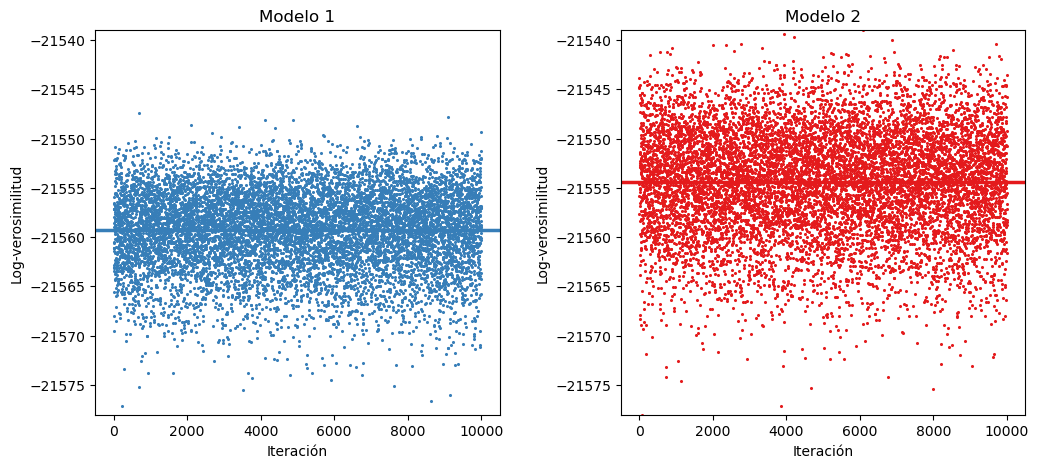

In [48]:
# Paleta de colores equivalente a RColorBrewer::brewer.pal(9, "Set1")[1:9]
col = sns.color_palette("Set1", 9)

# Extraer log-verosimilitudes
ll1 = chain1["THETA"]["ll"]
ll2 = chain2["THETA"]["ll"]

# Rango común para el eje y
yrange = (min(ll1.min(), ll2.min()), max(ll1.max(), ll2.max()))

# Configurar los gráficos lado a lado
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
plt.subplots_adjust(wspace=0.3)

# Modelo 1
axs[0].scatter(range(len(ll1)), ll1, color=col[1], s=1.5)
axs[0].axhline(np.mean(ll1), color=col[1], linewidth=2.5)
axs[0].set_ylim(yrange)
axs[0].set_xlabel("Iteración")
axs[0].set_ylabel("Log-verosimilitud")
axs[0].set_title("Modelo 1")

# Modelo 2
axs[1].scatter(range(len(ll2)), ll2, color=col[0], s=1.5)
axs[1].axhline(np.mean(ll2), color=col[0], linewidth=2.5)
axs[1].set_ylim(yrange)
axs[1].set_xlabel("Iteración")
axs[1].set_ylabel("Log-verosimilitud")
axs[1].set_title("Modelo 2")

plt.show()

In [49]:
# Tamaños efectivos de muestra (ESS) por columna
theta_df = chain2["THETA"]
neff2 = theta_df.apply(effective_size)

# Error estándar Monte Carlo (EEMC)
EEMC2 = theta_df.std(ddof=1) / np.sqrt(neff2)

# Coeficiente de variación Monte Carlo (en %)
CVMC2 = 100 * (EEMC2.abs() / theta_df.mean().abs())

# Resumen del tamaño efectivo de muestra
print("Tamaño efectivo de muestra:")
print(neff2.round(2).describe())

# Resumen del coeficiente de variación de Monte Carlo (CVMC1)
print("Coeficiente de variación Monte Carlo (%):")
print(CVMC2.round(2).describe())

Tamaño efectivo de muestra:
count       71.000000
mean      9269.004366
std        982.558137
min       5591.910000
25%       9098.185000
50%       9553.940000
75%      10000.000000
max      10000.000000
dtype: float64
Coeficiente de variación Monte Carlo (%):
count    71.000000
mean      0.110563
std       0.124761
min       0.000000
25%       0.020000
50%       0.070000
75%       0.120000
max       0.560000
dtype: float64


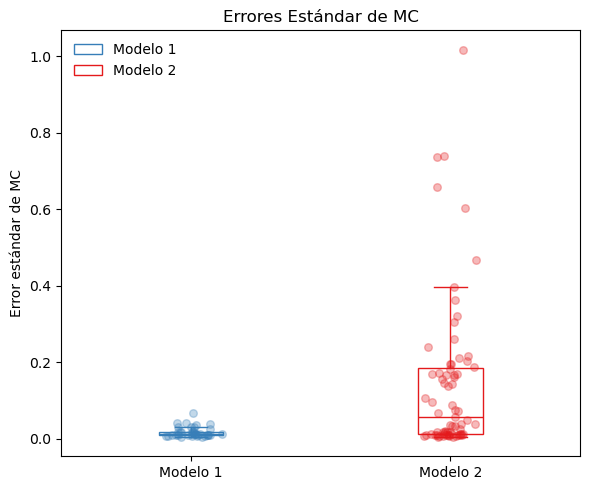

In [50]:
# Paleta de colores tipo Set1
col = sns.color_palette("Set1", 9)

# Crear figura
fig, ax = plt.subplots(figsize=(6, 5))

# Datos
data = [EEMC1, EEMC2]
positions = [1, 2]
colors = [col[1], col[0]]  # Modelo 1 = col[1], Modelo 2 = col[0]

# Dibujar boxplots sin relleno
for vals, pos, color in zip(data, positions, colors):
    ax.boxplot(vals,
               positions=[pos],
               widths=0.25,
               patch_artist=True,
               showfliers=False,
               boxprops=dict(facecolor="none", color=color),
               capprops=dict(color=color),
               whiskerprops=dict(color=color),
               flierprops=dict(markeredgecolor=color),
               medianprops=dict(color=color))

# Puntos individuales con jitter
jitter = 0.05
ax.scatter(np.random.normal(positions[0], jitter, size=len(EEMC1)), EEMC1,
           color=col[1], alpha=0.3, s=30)
ax.scatter(np.random.normal(positions[1], jitter, size=len(EEMC2)), EEMC2,
           color=col[0], alpha=0.3, s=30)

# Etiquetas y formato
ax.set_xticks(positions)
ax.set_xticklabels(["Modelo 1", "Modelo 2"], fontsize=10)
ax.set_xlim(0.5, 2.5)
ax.set_ylabel("Error estándar de MC")
ax.set_title("Errores Estándar de MC")

# Leyenda
ax.legend(["Modelo 1", "Modelo 2"], loc="upper left", frameon=False)

plt.tight_layout()
plt.show()

## Inferencia

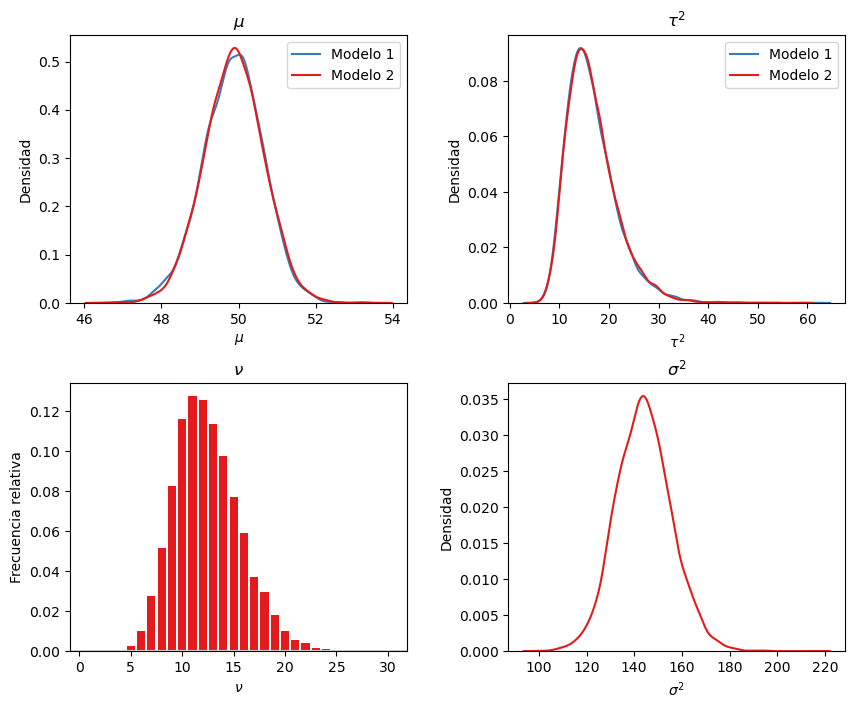

In [52]:
# Colores estilo Set1 de RColorBrewer
col = sns.color_palette("Set1", 9)

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# Posterior de mu
sns.kdeplot(chain1['THETA']['mu'], color=col[1], ax=axs[0, 0], label='Modelo 1')
sns.kdeplot(chain2['THETA']['mu'], color=col[0], ax=axs[0, 0], label='Modelo 2')
axs[0, 0].set_title(r'$\mu$')
axs[0, 0].set_xlabel(r'$\mu$')
axs[0, 0].set_ylabel("Densidad")
axs[0, 0].legend()

# Posterior de tau^2
sns.kdeplot(chain1['THETA']['tau2'], color=col[1], ax=axs[0, 1], label='Modelo 1')
sns.kdeplot(chain2['THETA']['tau2'], color=col[0], ax=axs[0, 1], label='Modelo 2')
axs[0, 1].set_title(r'$\tau^2$')
axs[0, 1].set_xlabel(r'$\tau^2$')
axs[0, 1].set_ylabel("Densidad")
axs[0, 1].legend()

# Posterior de nu (frecuencia relativa para valores 1 a 30)
nu_vals = chain2['THETA']['nu']
nu_counts = Counter(nu_vals)
nu_range = range(1, 31)
nu_freq = [nu_counts.get(i, 0) / len(nu_vals) for i in nu_range]

axs[1, 0].bar(nu_range, nu_freq, color=col[0])
axs[1, 0].axhline(0, color='lightgray')
axs[1, 0].set_xlabel(r'$\nu$')
axs[1, 0].set_ylabel("Frecuencia relativa")
axs[1, 0].set_title(r'$\nu$')

# Posterior de sigma^2 (ups2)
sns.kdeplot(chain2['THETA']['ups2'], color=col[0], ax=axs[1, 1])
axs[1, 1].set_title(r'$\sigma^2$')
axs[1, 1].set_xlabel(r'$\sigma^2$')
axs[1, 1].set_ylabel("Densidad")

plt.show()

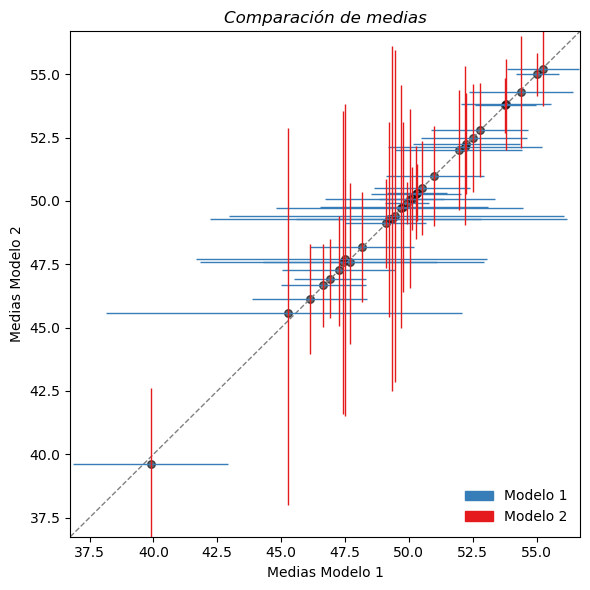

In [53]:
# Medias posteriores
theta_hat1 = chain1['THETA'].iloc[:, :m].mean(axis=0).to_numpy()
theta_hat2 = chain2['THETA'].iloc[:, :m].mean(axis=0).to_numpy()

# Intervalos de credibilidad al 95%
ic1 = np.quantile(chain1['THETA'].iloc[:, :m], q=[0.025, 0.975], axis=0)
ic2 = np.quantile(chain2['THETA'].iloc[:, :m], q=[0.025, 0.975], axis=0)

# Rango común para los ejes
rango_min = min(ic1.min(), ic2.min())
rango_max = max(ic1.max(), ic2.max())

# Colores estilo Set1 de RColorBrewer: rojo y azul
col = sns.color_palette("Set1", 9)
color_modelo1 = col[1]
color_modelo2 = col[0]

# Crear figura
plt.figure(figsize=(6, 6))
plt.xlim(rango_min, rango_max)
plt.ylim(rango_min, rango_max)
plt.xlabel("Medias Modelo 1")
plt.ylabel("Medias Modelo 2")
plt.title("Comparación de medias", fontsize=12, fontstyle='italic')

# Línea identidad
plt.plot([rango_min, rango_max], [rango_min, rango_max], linestyle='--', color='gray', linewidth=1)

# Puntos de medias
plt.scatter(theta_hat1, theta_hat2, color="black", alpha=0.6, s=30)

# Intervalos horizontales (Modelo 1)
for i in range(m):
    plt.hlines(y=theta_hat2[i], xmin=ic1[0, i], xmax=ic1[1, i], color=color_modelo1, linewidth=1)

# Intervalos verticales (Modelo 2)
for i in range(m):
    plt.vlines(x=theta_hat1[i], ymin=ic2[0, i], ymax=ic2[1, i], color=color_modelo2, linewidth=1)

# Leyenda personalizada
legend_elements = [
    Patch(facecolor=color_modelo1, edgecolor=color_modelo1, label='Modelo 1'),
    Patch(facecolor=color_modelo2, edgecolor=color_modelo2, label='Modelo 2')
]
plt.legend(handles=legend_elements, loc="lower right", frameon=False)

plt.tight_layout()
plt.show()


# Ejercicios

- Considere el modelo normal jerárquico con medias específicas por grupo y varianza común. Demuestre que la varianza marginal de las observaciones está dada por $\textsf{Var}(y_{i,j}) = \sigma^2 + \tau^2.$.

- Considere el modelo normal jerárquico con medias específicas por grupo y varianza común. Utilizando los datos de la prueba Saber 11 del segundo semestre de 2023:

    - Obtenga la distribución predictiva posterior para una nueva observación de en un grupo observado de su interés (e.g., Bogotá).
    - Obtenga la distribución predictiva posterior para una nueva observación de en un grupo no observado (i.e., un departamento hipotético del que no se tienen observaciones).
    - Evalúe la bondad de ajuste del modelo mediante un conjunto de estadísticos de prueba relevantes para un grupo observado de su interés (e.g., Bogotá), utilizando simulaciones de la distribución predictiva posterior.

- Considere el modelo $y_i \mid \theta, \sigma^2 \overset{\text{ind}}{\sim} \textsf{t}_\kappa(\theta_j, \sigma^2)$, para $i = 1, \dots, n$, donde $\kappa \sim \textsf{U}\{1, 2, \dots, \nu_0\}$, con $\nu_0$ como hiperparámetro. El resto del modelo se especifica de forma análoga al modelo normal jerárquico con medias específicas por grupo y varianza común.

    - Reescriba la distribución muestral del modelo utilizando variables auxiliares, mediante la representación de la distribución t como una composición de una distribución Normal con una distribución Gamma Inversa (véase los ejercicios del "Muestreador de Gibbs").
    - Derive las distribuciones condicionales completas de todos los parámetros del modelo.
    - Ajuste el modelo a los datos de la prueba Saber 11 del segundo semestre de 2023.
    - Identifique los valores atípicos (*outliers*) utilizando las variables auxiliares.
    - Realice toda la inferencia que se llevó a cabo en el caso del modelo normal jerárquico con medias específicas por grupo y varianza común.
    - Interprete y compare los resultados obtenidos con los del modelo normal jerárquico.

- Repetir el ejercicio anterior para el modelo $y_i \mid \theta, \sigma^2 \overset{\text{ind}}{\sim} \textsf{t}_\kappa(\theta_j, \sigma^2_j)$, para $i = 1, \dots, n$.

# Referencias

Hoff, P. D. (2009). *A First Course in Bayesian Statistical Methods*. Springer New York.

Gelman, A., Carlin, J. B., Stern, H. S., Dunson, D. B., Vehtari, A., & Rubin, D. B. (2013). *Bayesian Data Analysis* (3rd ed.). Chapman & Hall/CRC.